# SageMaker Pipelines - Invoking multi-tenant endpoint (SaaS)

This notebook demonstrates invoking a each tenant's model hosted on a SageMaker multi-model endpoint.

We will create a SageMaker mult-model endpoint that points to the S3 location of where  the model aritfacts were output by the SageMaker Pipeline(s).

This notebook has been tested on SageMaker Studio using the `Data Science` kernel on an `ml.t3.medium`. 


Please make sure your execution role attached to your Studio user profile has `iam:CreatePolicy, iam:CreateRole, iam:AttachRolePolicy and SageMakerFullAccess` permissions/policy attached.

---

##  Create single model endpoint for a tenant

### Set up

Below we will retrieve the the `image_uri` we will use to host the models with. We will be using the SageMaker Large Model Inference image. We will also set the S3 location where the tenant's model are saved so that the SageMaker endpoint can access it. 

In [1]:
import boto3

region = boto3.Session().region_name
# inference_image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/djl-ds:latest"
inference_image_uri = (
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.20.0-deepspeed0.7.5-cu116"
)

inference_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.20.0-deepspeed0.7.5-cu116'

### Use tenant1's model

We will deploy tenant1's model to a SageMaker endpoint. 

In [2]:
import sagemaker
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()

tenant_id = "tenant1"
app_id = "app1"
version= 0

model_location = f"s3://{default_bucket}/{tenant_id}/model_artifacts/{tenant_id}-{app_id}.model.{version}.tar.gz"

print(f"Tenant's model located at: {model_location}")

Tenant's model located at: s3://sagemaker-us-east-1-171503325295/tenant1/model_artifacts/tenant1-app1.model.0.tar.gz


### Create SageMaker Model entity

In [3]:
import time
from sagemaker import get_execution_role
sess = boto3.Session()
sm_client = sess.client("sagemaker")
role = get_execution_role()


sm_model_name = f"flan-t5-{tenant_id}-{app_id}" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_model_response = sm_client.create_model(
    ModelName=sm_model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": model_location
    },
    
)
model_arn = create_model_response["ModelArn"]

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:171503325295:model/flan-t5-tenant1-app12023-05-04-18-13-14


### Create SageMaker Endpoint Configuration

In [6]:
endpoint_config_name = f"flan-t5-{tenant_id}-{app_id}" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g5.12xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:171503325295:endpoint-config/flan-t5-tenant1-app12023-05-04-18-13-48


In [7]:
endpoint_name = f"flan-t5-{tenant_id}-{app_id}" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:171503325295:endpoint/flan-t5-tenant1-app12023-05-04-18-13-48


In [17]:
waiter = sm_client.get_waiter("endpoint_in_service")
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

print("Arn: " + resp["EndpointArn"])

Waiting for endpoint to create...
Endpoint Status: InService
Arn: arn:aws:sagemaker:us-east-1:171503325295:endpoint/flan-t5-tenant1-app12023-05-04-18-13-48


### Create ABAC role for invocation (Bridge approach)
In this section we create an IAM role which only allows to invocatipon to a tenant specific model.

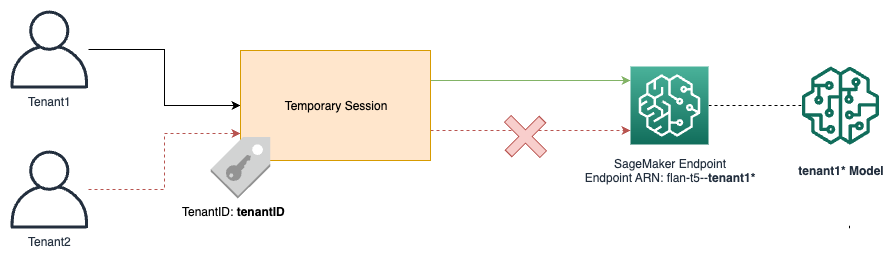

In [18]:
import boto3
import json
import sagemaker.session

sts = boto3.client('sts')
iam = boto3.client('iam')
region = boto3.session.Session().region_name
account_id = sts.get_caller_identity()['Account']

sagemaker_exec_role=sagemaker.session.get_execution_role().split('/')[-1]

invoke_policy_name="DemoTenantPipelineSMEInvokePolicy"

invoke_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "sagemaker:InvokeEndpoint",
            "Resource": f"arn:aws:sagemaker:{region}:{account_id}:endpoint/flan-t5-${{aws:PrincipalTag/TenantID}}-*"
        }
    ]
}

try:
    invoke_policy = iam.create_policy(
        PolicyName=invoke_policy_name,
        PolicyDocument=json.dumps(invoke_policy_document)
    )
    
except iam.exceptions.EntityAlreadyExistsException:
    # If the policy already exists, get its ARN
    policy = iam.get_policy(PolicyArn=f"arn:aws:iam::{account_id}:policy/{invoke_policy_name}")

    # Print the ARN of the existing IAM policy
    print(f"The IAM policy {invoke_policy_name} already exists with ARN {policy['Policy']['Arn']}")

inovke_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": f"arn:aws:sts::{account_id}:assumed-role/{sagemaker_exec_role}/SageMaker"
            },
            "Action": ["sts:AssumeRole","sts:TagSession"],
            "Condition": {
                "StringLike": {
                    "aws:RequestTag/TenantID": "*"
                }
            }
        }
    ]
}


try:
    invoke_role_name = "DemoTenantPipelineSMEInvokeRole"
    role=iam.create_role(
        RoleName=invoke_role_name,
        AssumeRolePolicyDocument=json.dumps(inovke_role_policy_document)
    )

    iam.attach_role_policy(
        RoleName=invoke_role_name,
        PolicyArn=f"arn:aws:iam::{account_id}:policy/{invoke_policy_name}"
    )
except iam.exceptions.EntityAlreadyExistsException:
    role = iam.get_role(RoleName=invoke_role_name)

    # Print the ARN of the existing IAM role
    print(f"The IAM role {invoke_role_name} already exists with ARN {role['Role']['Arn']}")

The IAM policy DemoTenantPipelineSMEInvokePolicy already exists with ARN arn:aws:iam::171503325295:policy/DemoTenantPipelineSMEInvokePolicy
The IAM role DemoTenantPipelineSMEInvokeRole already exists with ARN arn:aws:iam::171503325295:role/DemoTenantPipelineSMEInvokeRole


### Invoke tenant's model
For a given `tenant_id`, if you provide its `TargetModel` name (which will start with tenant id) you will be able to invoke the endpoint  successsfully. But if you provide `TargetModel` name of a different tenant you will get `AccessDeniedException`.

#### Create temp session for tenant1

In [24]:
from scripts import utils
tenant_id="tenant1"
invoke_temp_session = utils.create_temp_session(role['Role']['Arn'], tenant_id)

Assumed role ARN: arn:aws:sts::171503325295:assumed-role/DemoTenantPipelineSMEInvokeRole/tenant1


#### Invoke tenant1's model

In [26]:
import boto3
import json
import time
from scripts import utils

inputs = "Prompt: Why do gas prices change daily but other goods remain almost constant ? I understand that fruits and similar items can change in price due to the growing seasons , but even then it ’s not that much of a change . Why does gas change every day ? Explain like I'm five."

invoke_sagemaker_client = invoke_temp_session.client('sagemaker-runtime')

prompts = [inputs]
response_model = invoke_sagemaker_client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(
            {
                "inputs": prompts,
                
                "parameters": {
                    "min_length":25,
                    "max_length":100,
                    "temperature":1.0,
                    'do_sample': True,
                    'no_repeat_ngram_size': 2
                },
            }
            ),
            ContentType="application/json",
        )

output = json.loads(response_model['Body'].read().decode('utf8'))

print(output)

{'outputs': ['Theallstoresreadhousecommunity just googlemapcode your annual phone carrier andotic community just cell phone thats to memory recall-compavever city justrud :']}


#### Confirm tenant2 cant invoke tenant1's endpoint 

In [21]:
from scripts import utils
tenant_id="tenant2"
invoke_temp_session2 = utils.create_temp_session(role['Role']['Arn'], tenant_id)

Assumed role ARN: arn:aws:sts::171503325295:assumed-role/DemoTenantPipelineSMEInvokeRole/tenant2


In [22]:
invoke_sagemaker_client2 = invoke_temp_session2.client('sagemaker-runtime')

prompts = [inputs]
response_model = invoke_sagemaker_client2.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(
            {
                "inputs": prompts,
                
                "parameters": {
                    "min_length":25,
                    "max_length":100,
                    "temperature":1.0,
                    'do_sample': True,
                    'no_repeat_ngram_size': 2
                },
            }
            ),
            ContentType="application/json",
        )

output = json.loads(response_model['Body'].read().decode('utf8'))

print(output)

ClientError: An error occurred (AccessDeniedException) when calling the InvokeEndpoint operation: User: arn:aws:sts::171503325295:assumed-role/DemoTenantPipelineSMEInvokeRole/tenant2 is not authorized to perform: sagemaker:InvokeEndpoint on resource: arn:aws:sagemaker:us-east-1:171503325295:endpoint/flan-t5-tenant1-app12023-05-04-18-13-48 because no identity-based policy allows the sagemaker:InvokeEndpoint action